In [1]:
import glob, os, sys
import numpy as np
from nilearn.image import resample_img, index_img
import nibabel as nib
from nilearn.input_data import NiftiLabelsMasker

# Read data path and define result path

In [2]:
DATA_DIR = 'U:/Projects/CS_Analysis/CS_data/CS_brain_preprocessed'
crosscorr = 'data/data_cross_corr_Bzdok_DMN16_preprocessed'
nMasks = 16 #for sanity check

# Create a list of atlas names

In [3]:
atlas_nii = sorted(glob.glob('Bzdok_DMN/*.nii.gz'))
atlas_names = [roi.split(os.sep)[-1].split('.nii.gz')[0]  for roi in atlas_nii]
atlas_names = np.array(atlas_names)
# np.save(crosscorr+'_ROIS', atlas_names)

In [4]:
print atlas_names

['PMC-1' 'PMC-2' 'PMC-3' 'PMC-4' 'TPJ_left-1' 'TPJ_left-2' 'TPJ_right-1'
 'TPJ_right-2' 'dMPFC-1' 'dMPFC-3' 'vMPFC_Left_1' 'vMPFC_Left_2'
 'vMPFC_Left_3' 'vMPFC_Right_1' 'vMPFC_Right_2' 'vMPFC_Right_3']


# Create label nifti image

In [4]:
rs_niis = sorted(glob.glob(DATA_DIR + os.sep + '*.nii.gz'))
tmp_nii_path = rs_niis[0]
tmp_nii = nib.load(tmp_nii_path)

label_atlas = np.zeros(tmp_nii.shape[:3], dtype=np.int)
for i_roi, cur_roi in enumerate(atlas_nii):
    # reshape the data (put the mask on the particiapnt's data, matching the coordinates and shapes)
    re_cur_roi = resample_img(
        img=cur_roi,
        target_affine=tmp_nii.get_affine(),
        target_shape=tmp_nii.shape[:3],
        interpolation='nearest'
    )

    # binarize the data
    cur_data = re_cur_roi.get_data()
    if cur_data.ndim > 3:
        cur_data = cur_data[..., 0]
    cur_data_bin = np.array(cur_data > 0, dtype=np.int)
    label_atlas[cur_data_bin > 0] = i_roi + 1
#     re_cur_roi = nib.Nifti1Image(
#         cur_data_bin,
#         affine=tmp_nii.get_affine(),
#         header=tmp_nii.get_header()
#     )
    
#     # dump to disk
#     re_atlas_nii
#     re_cur_roi.to_filename('ReSample_Masks\\Yeo7LiberalMask_%i_%s.nii.gz'%(i+1, atlas_names[i])
label_atlas_nii = nib.Nifti1Image(
    label_atlas,
    affine=tmp_nii.affine,
    header=tmp_nii.header
)
# label_atlas_nii.to_filename('BzdokDMN16_labels.nii.gz')
masker = NiftiLabelsMasker(labels_img=label_atlas_nii, standardize=True,
                           memory='nilearn_cache', verbose=0)
masker.fit()

C:\Users\hw1012\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:10: DeprecationWarning: get_affine method is deprecated.
Please use the ``img.affine`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0


NiftiLabelsMasker(background_label=0, detrend=False, high_pass=None,
         labels_img=<nibabel.nifti1.Nifti1Image object at 0x0000000008CB5160>,
         low_pass=None, mask_img=None, memory='nilearn_cache',
         memory_level=1, resampling_target='data', smoothing_fwhm=None,
         standardize=True, t_r=None, verbose=0)

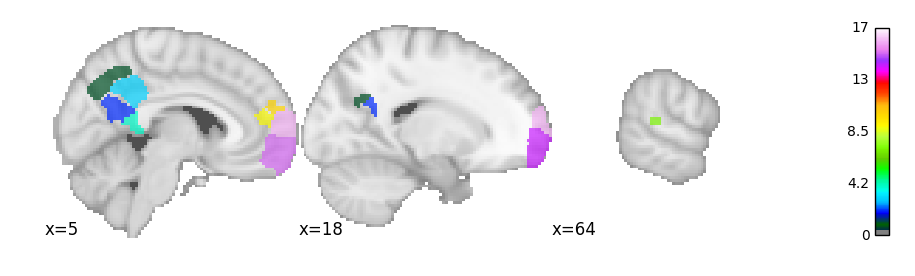

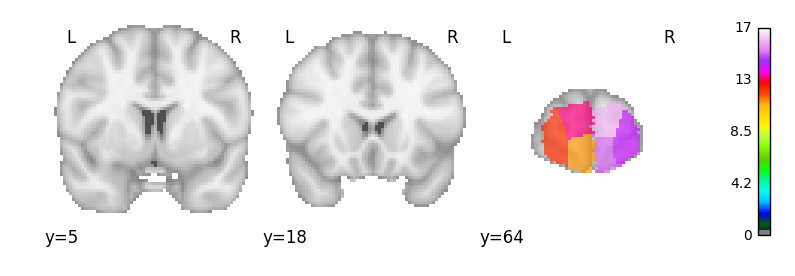

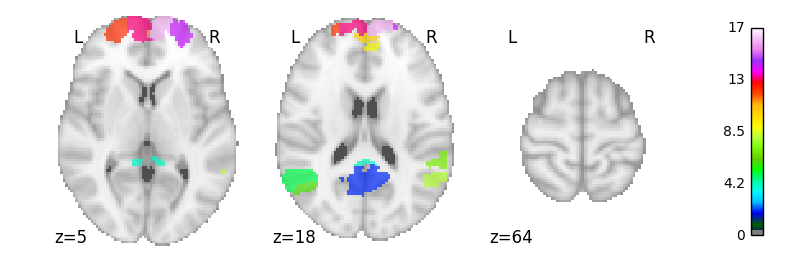

In [56]:
from nilearn import plotting
import matplotlib.pyplot as plt

plotting.plot_roi(label_atlas_nii, 
                  draw_cross=False,
                  colorbar=True,
                  display_mode='x',
                  cut_coords=(5, 64, 18),
                 vmax=17, vmin=0).savefig('Results/ROI_x.png', dpi=300)
plotting.show()

plotting.plot_roi(label_atlas_nii, 
                  draw_cross=False,
                  colorbar=True,
                  display_mode='y',
                  cut_coords=(5, 64, 18),
                 vmax=17, vmin=0).savefig('Results/ROI_y.png', dpi=300)
plotting.show()

plotting.plot_roi(label_atlas_nii, 
                  draw_cross=False,
                  colorbar=True,
                  display_mode='z',
                  cut_coords=(5, 64, 18),
                 vmax=17, vmin=0).savefig('Results/ROI_z.png', dpi=300)
plotting.show()

# Extract time series and compute network connectivities per particiapnt

In [94]:
corr_mat_vect_list = []
ind_list = []
FD_corr_mat_lst = []

FD = np.load('./data/CS1_FD.npy') # framewise displacement 

for i_rs_img, rs_img in enumerate(rs_niis):
    print('%i/%i: %s' % (i_rs_img + 1, len(rs_niis), rs_img))
    rs_reg_ts = masker.transform(rs_img)

    corr_mat = np.corrcoef(rs_reg_ts.T)
    triu_inds = np.triu_indices(corr_mat.shape[0], 1)
    corr_mat_vect = corr_mat[triu_inds]
    corr_mat_vect_list.append(corr_mat_vect)
    
    # how framewise displacement correlates with the signal from each node.
    FD_corr = np.hstack((rs_reg_ts, FD[i_rs_img:i_rs_img+1, :].T))
    FD_corr_mat = np.corrcoef(FD_corr.T)
    FD_corr_mat_lst.append(FD_corr_mat)
    
corr_mat_vect_array = np.array(corr_mat_vect_list)
FD_corr_mat = np.array(FD_corr_mat_lst)

#demean
corr_mat_vect_array[np.isnan(corr_mat_vect_array)] = 1
# np.save(crosscorr, corr_mat_vect_array)

1/165: U:/Projects/CS_Analysis/CS_data/CS_brain_preprocessed\001_R4087_MNI152_2mm_prepro_filtered_func_data.nii.gz
2/165: U:/Projects/CS_Analysis/CS_data/CS_brain_preprocessed\002_R4088_MNI152_2mm_prepro_filtered_func_data.nii.gz
3/165: U:/Projects/CS_Analysis/CS_data/CS_brain_preprocessed\003_R4076_MNI152_2mm_prepro_filtered_func_data.nii.gz
4/165: U:/Projects/CS_Analysis/CS_data/CS_brain_preprocessed\004_R3529_MNI152_2mm_prepro_filtered_func_data.nii.gz
5/165: U:/Projects/CS_Analysis/CS_data/CS_brain_preprocessed\005_R4071_MNI152_2mm_prepro_filtered_func_data.nii.gz
6/165: U:/Projects/CS_Analysis/CS_data/CS_brain_preprocessed\006_R3392_MNI152_2mm_prepro_filtered_func_data.nii.gz
7/165: U:/Projects/CS_Analysis/CS_data/CS_brain_preprocessed\007_R4064_MNI152_2mm_prepro_filtered_func_data.nii.gz
8/165: U:/Projects/CS_Analysis/CS_data/CS_brain_preprocessed\008_R4079_MNI152_2mm_prepro_filtered_func_data.nii.gz
9/165: U:/Projects/CS_Analysis/CS_data/CS_brain_preprocessed\009_R4086_MNI152_2m

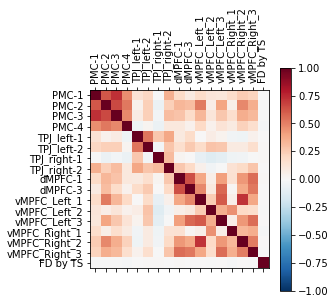

In [95]:
# plot the average network strength 
# and the correlation between framewise displacement and TS of the ROIs

atlas_names = [roi.split(os.sep)[-1].split('.nii.gz')[0]  for roi in atlas_nii] + ['FD by TS']
mean_NetworkStrength = np.mean(FD_corr_mat, axis=0)

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 10})
plt.matshow(mean_NetworkStrength, vmin=-1, vmax=1, cmap=plt.cm.RdBu_r)
# plt.plot([-0.5, n_areas-0.5], [-0.5, n_areas-0.5], ls='--', c='.3')
plt.xticks(range(mean_NetworkStrength.shape[0]), atlas_names, rotation=90)
plt.yticks(range(mean_NetworkStrength.shape[1]), atlas_names)
plt.colorbar()
plt.show()
# plt.savefig('./Results/RemoveHighFD/FDbyTS_nodeSignal_corrmat.png', bbox_inches='tight', dpi=150)

In [10]:
# save all combinations
reg_reg_names = [atlas_names[a] + ' vs ' + atlas_names[b] for (a,b) in zip(triu_inds[0], triu_inds[1])]
np.save(crosscorr+'_keys', reg_reg_names)

# Create a total network mask

In [44]:
network_nii = np.zeros(tmp_nii.shape[:3], dtype=np.int)
network_nii[label_atlas>0] = 1
network_mask = nib.Nifti1Image(
    network_nii,
    affine=tmp_nii.affine,
    header=tmp_nii.header
)
network_mask.to_filename('BzdokDMN16_network_mask.nii.gz')